In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS

from cli import get_file_paths
import plotting
import pipeline

In [4]:
type_key = 'LF1'
site_key = "Carp"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = True
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'assemble_location_summary': False,
 'read_csv': True,
 'save_activity_grid': False,
 'save_presence_grid': False,
 'save_dc_night_comparisons': False,
 'save_activity_dc_comparisons': False,
 'save_presence_dc_comparisons': False,
 'show_plots': False,
 'show_PST': True}

In [6]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Carp Pond',
 'site_tag': 'Carp',
 'type_tag': 'LF1',
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [7]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'bd2_TYPE_SITE_YEAR': 'bd2__LF1Carp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LF1Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LF1Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LF1Carp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF1Carp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF1Carp',
 'activity_bout_comparisons_figname': 'activity_bout_comparisons_per_dc_LF1Carp',
 'dc_bou

In [8]:
def assemble_initial_location_summary(data_params, file_paths, save=True):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv').compute()
    location_df['low_freq'] = location_df['low_freq'].astype('float')
    location_df['high_freq'] = location_df['high_freq'].astype('float')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
    location_df.insert(0, 'freq_group', '')

    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups[list(groups.keys())[0]]
    red_group = groups[list(groups.keys())[1]]
    yellow_group = groups[list(groups.keys())[2]]

    call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
    call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
    call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

    location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'
    
    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]


    return location_df

In [9]:
assemble_initial_location_summary(data_params, file_paths, save=False)

freq_group                   ref_time            call_start_time  \
0         LF1 2022-07-13 04:53:00.335500 2022-07-13 04:53:00.335500   
1         LF1 2022-07-13 04:55:13.597500 2022-07-13 04:55:13.597500   
2         LF1 2022-07-13 04:55:13.823500 2022-07-13 04:55:13.823500   
3         LF1 2022-07-13 04:55:13.988500 2022-07-13 04:55:13.988500   
4         LF1 2022-07-13 04:55:14.267500 2022-07-13 04:55:14.267500   
..        ...                        ...                        ...   
46        LF1 2022-10-17 07:56:40.667500 2022-10-17 07:56:40.667500   
47        LF1 2022-10-17 07:56:41.303500 2022-10-17 07:56:41.303500   
48        LF1 2022-10-17 07:56:41.547500 2022-10-17 07:56:41.547500   
49        LF1 2022-10-17 07:56:42.025500 2022-10-17 07:56:42.025500   
50        LF1 2022-10-17 07:56:42.396500 2022-10-17 07:56:42.396500   

                call_end_time start_time   end_time  low_freq  high_freq  \
0  2022-07-13 04:53:00.353200  1380.3355  1380.3532   28046.0    31703.0   
1  2022-07-13 04:55:13.612900  1513.5975  1513.6129   23750.0    28075.0   
2  2022-07-13 04:55:13.839600  1513.8235  1513.8396   23750.0    28002.0   
3  2022-07-13 04:55:14.001000  1513.9885   1514.001   24609.0    30884.0   
4  2022-07-13 04:55:14.283900  1514.2675  1514.2839   23750.0    28526.0   
..                        ...        ...        ...       ...        ...   
46 2022-10-17 07:56:40.683800  1600.6675  1600.6838   25468.0    29006.0   
47 2022-10-17 07:56:41.318500  1601.3035  1601.3185   24609.0    28681.0   
48 2022-10-17 07:56:41.562300  1601.5475  1601.5623   25468.0    29256.0   
49 2022-10-17 07:56:42.039100  1602.0255  1602.0391   25468.0    30005.0   
50 2022-10-17 07:56:42.410600  1602.3965  1602.4106   25468.0    28304.0   

           event              class class_prob det_prob individual  \
0   Echolocation  Nyctalus leisleri      0.487    0.559         -1   
1   Echolocation  Nyctalus leisleri      0.449    0.571         -1   
2   Echolocation  Nyctalus leisleri      0.513    0.591         -1   
3   Echolocation  Nyctalus leisleri      0.424    0.632         -1   
4   Echolocation  Nyctalus leisleri      0.459    0.587         -1   
..           ...                ...        ...      ...        ...   
46  Echolocation  Nyctalus leisleri      0.441    0.559         -1   
47  Echolocation  Nyctalus leisleri      0.504    0.613         -1   
48  Echolocation  Nyctalus leisleri      0.409    0.574         -1   
49  Echolocation  Nyctalus leisleri      0.432    0.599         -1   
50  Echolocation  Nyctalus leisleri      0.454    0.541         -1   

                                           input_file  Site name  \
0   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
1   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
2   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
3   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
4   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
..                                                ...        ...   
46  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
47  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
48  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
49  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
50  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   

      Recover Folder  SD Card  
0               <NA>      NaN  
1               <NA>      NaN  
2               <NA>      NaN  
3               <NA>      NaN  
4               <NA>      NaN  
..               ...      ...  
46  recover-20221017     10.0  
47  recover-20221017     10.0  
48  recover-20221017     10.0  
49  recover-20221017     10.0  
50  recover-20221017     10.0  

[964132 rows x 17 columns]

In [10]:
pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)

freq_group                       ref_time                call_start_time  \
0         LF1  2022-07-13 04:53:00.335500000  2022-07-13 04:53:00.335500000   
1         LF1  2022-07-13 04:55:13.597500000  2022-07-13 04:55:13.597500000   
2         LF1  2022-07-13 04:55:13.823500000  2022-07-13 04:55:13.823500000   
3         LF1  2022-07-13 04:55:13.988500000  2022-07-13 04:55:13.988500000   
4         LF1  2022-07-13 04:55:14.267500000  2022-07-13 04:55:14.267500000   
..        ...                            ...                            ...   
46        LF1  2022-10-17 07:56:40.667500000  2022-10-17 07:56:40.667500000   
47        LF1  2022-10-17 07:56:41.303500000  2022-10-17 07:56:41.303500000   
48        LF1  2022-10-17 07:56:41.547500000  2022-10-17 07:56:41.547500000   
49        LF1  2022-10-17 07:56:42.025500000  2022-10-17 07:56:42.025500000   
50        LF1  2022-10-17 07:56:42.396500000  2022-10-17 07:56:42.396500000   

                    call_end_time  start_time   end_time  low_freq  high_freq  \
0   2022-07-13 04:53:00.353200000   1380.3355  1380.3532   28046.0    31703.0   
1   2022-07-13 04:55:13.612900000   1513.5975  1513.6129   23750.0    28075.0   
2   2022-07-13 04:55:13.839600000   1513.8235  1513.8396   23750.0    28002.0   
3   2022-07-13 04:55:14.001000000   1513.9885  1514.0010   24609.0    30884.0   
4   2022-07-13 04:55:14.283900000   1514.2675  1514.2839   23750.0    28526.0   
..                            ...         ...        ...       ...        ...   
46  2022-10-17 07:56:40.683800000   1600.6675  1600.6838   25468.0    29006.0   
47  2022-10-17 07:56:41.318500000   1601.3035  1601.3185   24609.0    28681.0   
48  2022-10-17 07:56:41.562300000   1601.5475  1601.5623   25468.0    29256.0   
49  2022-10-17 07:56:42.039100000   1602.0255  1602.0391   25468.0    30005.0   
50  2022-10-17 07:56:42.410600000   1602.3965  1602.4106   25468.0    28304.0   

           event              class  class_prob  det_prob  individual  \
0   Echolocation  Nyctalus leisleri       0.487     0.559          -1   
1   Echolocation  Nyctalus leisleri       0.449     0.571          -1   
2   Echolocation  Nyctalus leisleri       0.513     0.591          -1   
3   Echolocation  Nyctalus leisleri       0.424     0.632          -1   
4   Echolocation  Nyctalus leisleri       0.459     0.587          -1   
..           ...                ...         ...       ...         ...   
46  Echolocation  Nyctalus leisleri       0.441     0.559          -1   
47  Echolocation  Nyctalus leisleri       0.504     0.613          -1   
48  Echolocation  Nyctalus leisleri       0.409     0.574          -1   
49  Echolocation  Nyctalus leisleri       0.432     0.599          -1   
50  Echolocation  Nyctalus leisleri       0.454     0.541          -1   

                                           input_file  Site name  \
0   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
1   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
2   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
3   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
4   /mnt/ubna_data_01/recover-20220715/UBNA_008/20...  Carp Pond   
..                                                ...        ...   
46  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
47  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
48  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
49  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   
50  /mnt/ubna_data_02/recover-20221017/UBNA_010/20...  Carp Pond   

      Recover Folder  SD Card  
0                NaN      NaN  
1                NaN      NaN  
2                NaN      NaN  
3                NaN      NaN  
4                NaN      NaN  
..               ...      ...  
46  recover-20221017     10.0  
47  recover-20221017     10.0  
48  recover-20221017     10.0  
49  recover-20221017     10.0  
50  recover-20221017     10.0  

[9

In [11]:
activity_arr = ss.construct_activity_dets_arr_from_dc_tags(data_params, file_paths)

In [12]:
activity_arr[8*23:9*23]

Number_of_Detections (1800of1800)  \
Date_and_Time_UTC                                        
2022-07-21 02:00:00                                0.0   
2022-07-21 02:30:00                                0.0   
2022-07-21 03:00:00                                3.0   
2022-07-21 03:30:00                                1.0   
2022-07-21 04:00:00                                0.0   
2022-07-21 04:30:00                                0.0   
2022-07-21 05:00:00                              230.0   
2022-07-21 05:30:00                              210.0   
2022-07-21 06:00:00                              146.0   
2022-07-21 06:30:00                              452.0   
2022-07-21 07:00:00                              120.0   
2022-07-21 07:30:00                              114.0   
2022-07-21 08:00:00                              364.0   
2022-07-21 08:30:00                             2805.0   
2022-07-21 09:00:00                             3077.0   
2022-07-21 09:30:00                             5495.0   
2022-07-21 10:00:00                             4025.0   
2022-07-21 10:30:00                             3822.0   
2022-07-21 11:00:00                             3170.0   
2022-07-21 11:30:00                              204.0   
2022-07-21 12:00:00                                3.0   
2022-07-21 12:30:00                                2.0   
2022-07-21 13:00:00                                2.0   

                     Number_of_Detections (300of1800)  \
Date_and_Time_UTC                                       
2022-07-21 02:00:00                               0.0   
2022-07-21 02:30:00                               0.0   
2022-07-21 03:00:00                               0.0   
2022-07-21 03:30:00                               0.0   
2022-07-21 04:00:00                               0.0   
2022-07-21 04:30:00                               0.0   
2022-07-21 05:00:00                               0.0   
2022-07-21 05:30:00                               1.0   
2022-07-21 06:00:00                               0.0   
2022-07-21 06:30:00                               1.0   
2022-07-21 07:00:00                               5.0   
2022-07-21 07:30:00                               2.0   
2022-07-21 08:00:00                              87.0   
2022-07-21 08:30:00                             105.0   
2022-07-21 09:00:00                             616.0   
2022-07-21 09:30:00                             226.0   
2022-07-21 10:00:00                            1217.0   
2022-07-21 10:30:00                             949.0   
2022-07-21 11:00:00                             634.0   
2022-07-21 11:30:00                             159.0   
2022-07-21 12:00:00                               0.0   
2022-07-21 12:30:00                               0.0   
2022-07-21 13:00:00                               1.0   

                     Number_of_Detections (60of360)  
Date_and_Time_UTC                                    
2022-07-21 02:00:00                             0.0  
2022-07-21 02:30:00                             0.0  
2022-07-21 03:00:00                             0.0  
2022-07-21 03:30:00                             0.0  
2022-07-21 04:00:00                             0.0  
2022-07-21 04:30:00                             0.0  
2022-07-21 05:00:00                            57.0  
2022-07-21 05:30:00                            30.0  
2022-07-21 06:00:00                             7.0  
2022-07-21 06:30:00                           201.0  
2022-07-21 07:00:00                            30.0  
2022-07-21 07:30:00                            37.0  
2022-07-21 08:00:00                           110.0  
2022-07-21 08:30:00                           411.0  
2022-07-21 09:00:00                           599.0  
2022-07-21 09:30:00                           809.0  
2022-07-21 10:00:00                           847.0  
2022-07-21 10:30:00                           629.0  
2022-07-21 11:00:00                           491.0  
2022-07-21

In [13]:
activity_arr = pipeline.run_for_dets(data_params, pipeline_params, file_paths)

In [14]:
dh.construct_activity_grid_for_number_of_dets(activity_arr, "1800of1800")

Date (UTC)  07/13/22  07/14/22  07/15/22  07/16/22  07/17/22  07/18/22  \
Time (UTC)                                                               
02:00            0.0       0.0       0.0       1.0       0.0       0.0   
02:30            0.0       0.0       0.0       0.0       1.0       1.0   
03:00            0.0       0.0       0.0       0.0       1.0       0.0   
03:30            0.0       0.0       0.0       0.0       0.0       0.0   
04:00            0.0       0.0       0.0      13.0       0.0       0.0   
04:30           43.0       0.0       0.0     135.0       0.0     117.0   
05:00           38.0      24.0      62.0     602.0      86.0      88.0   
05:30          194.0       2.0     162.0    3452.0     199.0    3411.0   
06:00          127.0      74.0    2928.0    3924.0     228.0    2770.0   
06:30           42.0     271.0    3141.0    3628.0     739.0     334.0   
07:00          469.0      44.0    2403.0    5100.0    2110.0    2169.0   
07:30          333.0       7.0    1959.0    3405.0    1291.0    1292.0   
08:00           21.0     439.0     364.0    2390.0     694.0    2746.0   
08:30           72.0     897.0     309.0    2400.0     514.0    1706.0   
09:00           64.0     160.0     783.0    1012.0      96.0     875.0   
09:30           19.0      77.0     210.0    2156.0      21.0     409.0   
10:00           24.0       9.0     166.0    1630.0      35.0     301.0   
10:30           60.0       0.0     277.0     190.0     300.0     312.0   
11:00            2.0       0.0     261.0      92.0     128.0       0.0   
11:30            0.0       0.0       0.0       0.0       0.0      14.0   
12:00            0.0       0.0       0.0       0.0       0.0       0.0   
12:30            0.0       0.0       0.0       0.0       0.0       1.0   
13:00            0.0       0.0       NaN       0.0       0.0       0.0   

Date (UTC)  07/19/22  07/20/22  07/21/22  07/22/22  ...  10/08/22  10/09/22  \
Time (UTC)                                          ...                       
02:00            0.0       0.0       0.0       1.0  ...     129.0    1050.0   
02:30            0.0       0.0       0.0       0.0  ...     983.0     622.0   
03:00            0.0       2.0       3.0       2.0  ...     764.0    4192.0   
03:30            0.0       0.0       1.0       1.0  ...     796.0     893.0   
04:00            0.0       1.0       0.0       1.0  ...     187.0    1224.0   
04:30          132.0      14.0       0.0       0.0  ...      53.0     328.0   
05:00          109.0      89.0     230.0     829.0  ...       0.0       0.0   
05:30          222.0     276.0     210.0     816.0  ...       1.0       0.0   
06:00          204.0     591.0     146.0     250.0  ...       0.0       0.0   
06:30           54.0     330.0     452.0     167.0  ...       0.0       0.0   
07:00           47.0    4891.0     120.0    5030.0  ...       0.0       0.0   
07:30          228.0    5683.0     114.0    8077.0  ...     253.0       0.0   
08:00           93.0    4862.0     364.0    9286.0  ...       0.0       0.0   
08:30          124.0    6553.0    2805.0    7461.0  ...       0.0       0.0   
09:00            4.0    7283.0    3077.0    8561.0  ...       0.0       2.0   
09:30          136.0    8550.0    5495.0    5677.0  ...       0.0       0.0   
10:00            4.0    7534.0    4025.0     934.0  ...       0.0       0.0   
10:30           30.0    5587.0    3822.0    2587.0  ...       0.0       0.0   
11:00          177.0    6415.0    3170.0    4981.0  ...       0.0       0.0   
11:30            2.0     240.0     204.0    2564.0  ...       0.0       1.0   
12:00            1.0       1.0       3.0       0.0  ...       0.0       1.0   
12:30            0.0       2.0       2.0       0.0  ...       0.0       0.0   
13:00            0.0       0.0       2.0       1.0  ...       0.0       0.0   

Date (UTC)  10/10/22  10/11/22  10/12/22  10/13/22  10/14/22  10/15/22  \
Time (UTC)                                                               
02:00          401.0     

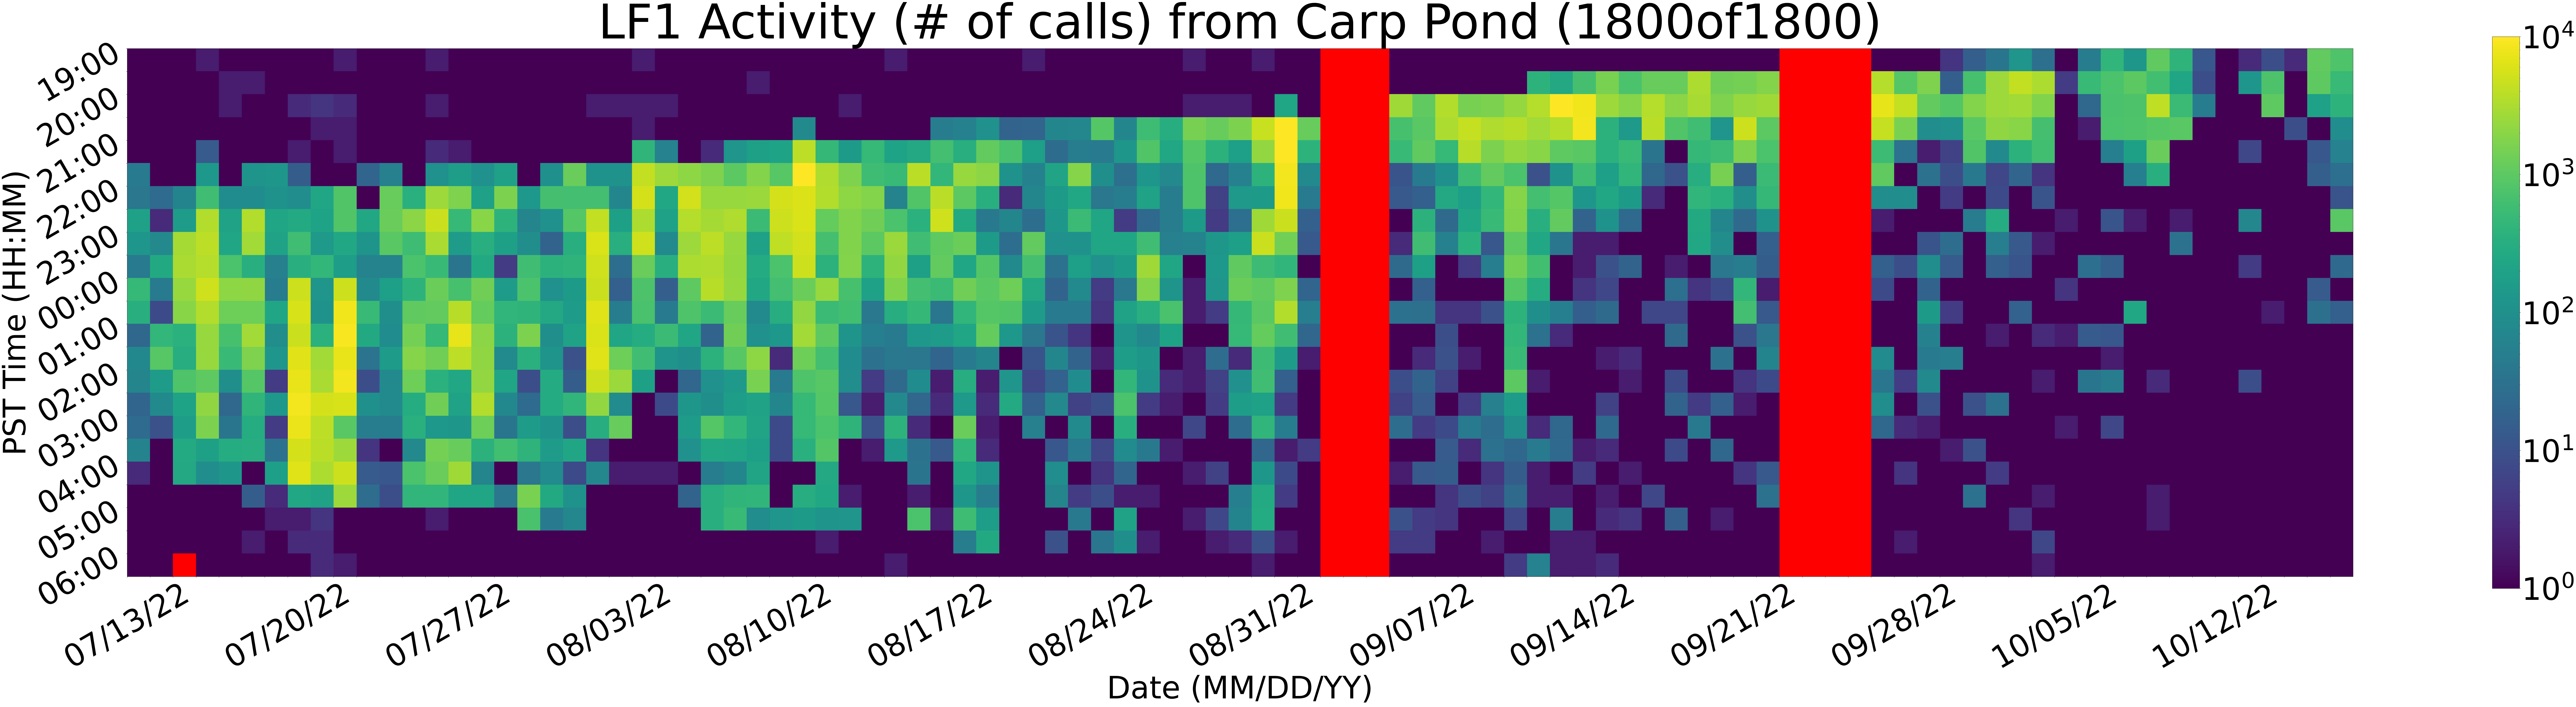

In [15]:
plotting.plot_activity_grid_for_dets(dh.construct_activity_grid_for_number_of_dets(activity_arr, data_params["cur_dc_tag"]), data_params, pipeline_params, file_paths)

In [16]:
# plotting.plot_presence_grid(dh.construct_presence_grid(activity_arr, data_params["cur_dc_tag"]), data_params, pipeline_params, file_paths)
# plotting.plot_dc_dets_comparisons_per_night(activity_arr, data_params, pipeline_params, file_paths)

In [17]:
plotting.plot_dc_det_activity_comparisons_per_scheme(activity_arr, data_params, pipeline_params, file_paths)

In [18]:
# plotting.plot_dc_presence_comparisons_per_scheme(activity_arr, data_params, pipeline_params, file_paths)

In [19]:
# pipeline.plot_dets(activity_arr, data_params, pipeline_params, file_paths)